<a href="https://colab.research.google.com/github/jtorom/jtorom/blob/develop/Rocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp -r /content/drive/MyDrive/Palas\ fotos/Fotos\ contorneadas/labelme/*.* /content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/data/Train/

In [ ]:
#!cp -r /content/drive/MyDrive/Palas\ fotos/Distribución\ de\ Imágenes/Imágenes\ Jonathan\ T./Test/*.* /content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/data/Test/

In [1]:
import os
path = '/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train/'
jpg_count = len([f for f in os.listdir(path) if f.endswith('.jpg')])
print(jpg_count)

191


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')
#Descarga de las librerias de Mask RCNN de matterport
#!git clone https://github.com/matterport/Mask_RCNN Version antigua
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN'):
  !git clone https://github.com/masc-it/Mask-RCNN.git #version mejorada


In [2]:
folder="rock_data20231210T0032/"
if not os.path.exists("/content/logs/"+folder):
  os.makedirs("/content/logs")
  os.chdir("/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs")
  os.system("cp -r "+ folder +" /content/logs/"+folder)


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')
%cd Mask-RCNN
#!pip list
!pip3 install -r requirements.txt
!python3 setup.py install

In [ ]:
#Descarga de la matriz de pesos COCO.h5
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/cocoapi'):
  !git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../


/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I../common -I/usr/include/python3.10 -c ../common/maskApi.c -o build/temp.linux-x86_64-cpython-310/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wmisleading-indentation-Wmisleading-indentation]8;;]
   46 |       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=

In [3]:
DEVICE = "/gpu:0"


In [4]:
import tensorflow as tf
import skimage as ski
print(ski.__version__)

with tf.device('/device:GPU:0'):
  if not (ski.__version__=="0.16.2"):
    !pip uninstall --yes scikit-image
    if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/ski/scikit-image-0.16.2.tar.gz"):
      !pip download --destination-directory "/content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/ski/" scikit-image==0.16.2
    #!pip install scikit-image==0.16.2
    #!pip install --no-index --find-links "/content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/ski/" scikit-image
    !pip install --find-links "/content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/ski/" scikit-image==0.16.2
    os.kill(os.getpid(), 9)


0.16.2


In [5]:

import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import imgaug
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense,Flatten , Conv2D , MaxPooling2D , Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import datetime

In [6]:
ROOT_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')

sys.path.append(ROOT_DIR)

In [7]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/')
from mrcnn.config import Config
from mrcnn import utils
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/mrcnn/')
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
%matplotlib inline

In [8]:

# Directorio donde se guaradaran los logs y los modelos de entrenamiento [en root dir- logs]
MODEL_DIR = os.path.abspath('/content/logs')
#MODEL_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs')

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)


# Directorio donde se guardara el archivo de pesos COCO.h5
COCO_MODEL_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs/mask_rcnn_coco.h5')


In [ ]:
# Se comprueba que se haya descargado correctamente el archivo COCO.h5
if os.path.exists(os.path.join(COCO_MODEL_PATH)):
  print("coco model exist")
%cd /content/drive/MyDrive/Colab Notebooks/WorkspaceTesis
!ls

coco model exist
/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis
 8433365521_9252889f9a_z.jpg			    logs
 ColorPanoptic.png				    Mask-RCNN
 convnext_large_kmax_deeplab_coco_train_unlabeled   mask_rcnn_coco.h5
 data						    pruebasVarias.ipynb
 DeeepLab_COCO.py				    requirements.txt
 DeepLab_COCO.ipynb				    sample2.jpg
 deeplabv3_xception_tf_dim_ordering_tf_kernels.h5   ski
 events.out.tfevents.1700080742.48232b430e14	    sphx_glr_plot_visualization_utils_001.png
'Kaggle y Maskrcnn.ipynb'


In [9]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
DATA_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/')

In [10]:
#Craci n de los directorios de validaci n , test y train
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/')
DATASET_TRAIN_DIR=os.path.join(DATA_DIR,'Train')
DATASET_VAL_DIR=os.path.join(DATA_DIR,'Validation')
DATASET_TEST_DIR=os.path.join(DATA_DIR,'Test')


#Crea com una configuraci n a partir de tensorflow, ConfigProto()
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



In [11]:
path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train'
imageSize = [350, 536,3]
sizeEpochSteps = jpg_count ##mismo valor que la cantidad de img en train

def ajustarTamano(path):
  os.chdir(path)
  for i,f in enumerate(os.listdir('.')):

    file_name, file_extension = os.path.splitext(f)
    #print(file_extension)
    if os.path.isfile(f) and file_extension=='.jpg':
      try:

        image_path_jpg = f
        print(image_path_jpg)
        img = tf.io.read_file(image_path_jpg)
        #print(img.get_shape().as_list()) # []
        img = tf.image.decode_jpeg(img)
        #print(img.get_shape().as_list())
        img_resized = tf.image.resize(img, [imageSize[0], imageSize[1]])
        img_resized = img_resized.eval(session=session)
        #print(type(img_resized))
        img_resized_tensor = tf.reshape(img_resized, [imageSize[0], imageSize[1]] )
        img_resized = img_resized_tensor.eval(session=session)
        cv2.imwrite(f, img_resized)
      except:
        print("Error en :" , f)


#path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train'
#ajustarTamano(path)
#path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Test'
#ajustarTamano(path)
#path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Validation'
#ajustarTamano(path)

In [12]:
#Creacin de las clases partiendo de config
class Rocks(Config):
  # Definici n de la clase general
  NAME ="rock_Data"
  # Se ajusta n mero de imagenes a cada GPU.
  IMAGES_PER_GPU = 1
  # Defino numero de clases incluyendo el background
  NUM_CLASSES = 2 #Background + rock"
  # Numero de steps por cada epoca
  STEPS_PER_EPOCH = sizeEpochSteps # Se pone el mismo n mero de imagenes que hay en la carpeta Train
  # Precisi n del sistema (en el proceso de validaci n)
  DETECTION_MIN_CONFIDENCE = 0.25
  # MiniMask
  USE_MINI_MASK = False
  IMAGE_SHAPE = imageSize
  BATCH_SIZE =4
  LEARNING_RATE=0.005

In [ ]:
config = Rocks()
config.display()

In [14]:
from PIL import Image,ImageDraw
axis_Width = 15

In [15]:
#Hereda de la clase Dataset en el fichero utils.
class RocksDataset(utils.Dataset):

  def load_dataset(self, dataset_dir):

    self.add_class('dataset', 1, 'rock')

    for i, filename in enumerate(os.listdir(dataset_dir)):
      annotation_file = os.path.join(dataset_dir , filename.replace('.jpg', '.json'))
      if '.jpg' in filename and os.path.isfile(annotation_file):
        self.add_image('dataset',image_id=i,path=os.path.join(dataset_dir , filename),annotation=annotation_file)

  def extract_masks(self, filename):
    json_file = os.path.join(filename) #Devuelve el nombre del fichero con string->’.
    with open(json_file) as f:
      img_anns = json.load(f)
    n_masks = 0
    for anno in img_anns['shapes']:
      if anno['label']=='rock':
        n_masks+=1#
    masks = np.zeros([img_anns['imageHeight'], img_anns['imageWidth'], n_masks], dtype='uint8')
    classes = []#
    i=0
    for anno in img_anns['shapes']:
      if anno['label']=='rock':
        mask = np.zeros([img_anns['imageHeight'], img_anns['imageWidth']], dtype=np.uint8)
        cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
        masks[:, :, i] = mask
        classes.append(self.class_names.index(anno['label']))
        i+=1
    return masks , classes

  # Carga las m scaras para una imagen
  def load_mask(self, image_id):
    info = self.image_info[image_id]
    path = info['annotation']
    masks, classes = self.extract_masks(path)
    return masks, np.asarray(classes, dtype='int32')

  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']




In [16]:
dataset_train = RocksDataset()
dataset_train.load_dataset(DATASET_TRAIN_DIR)
dataset_train.prepare()


In [17]:
#Para comprobar que las imagenes se han cargado bien
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
  print("{:3}. {:50}".format(i, info['name']))


Image Count: 191
Class Count: 2
  0. BG                                                
  1. rock                                              


In [18]:
# Validation set
dataset_val = RocksDataset()
dataset_val.load_dataset(DATASET_VAL_DIR)
dataset_val.prepare()

In [19]:
#Para comprobar que las imagenes se han cargado bien
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
  print("{:3}. {:50}".format(i, info['name']))

Image Count: 23
Class Count: 2
  0. BG                                                
  1. rock                                              


In [20]:
#Test set
dataset_test = RocksDataset()
dataset_test.load_dataset(DATASET_TEST_DIR)
dataset_test.prepare()
print('Test: %d images' % len(dataset_test.image_ids))

Test: 28 images


In [21]:
#Para comprobar que las imagenes se han cargado bien
print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
  print("{:3}. {:50}".format(i, info['name']))


Image Count: 28
Class Count: 2
  0. BG                                                
  1. rock                                              


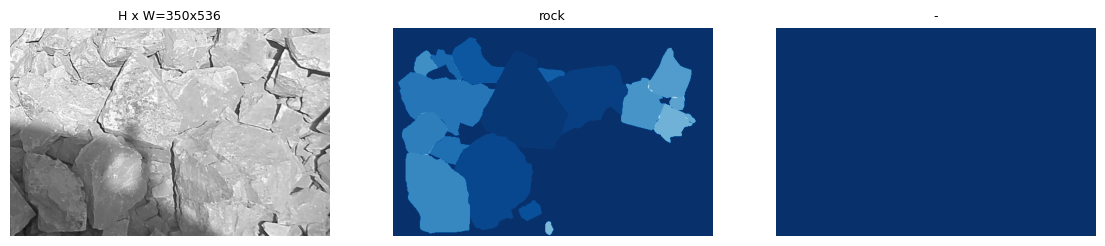

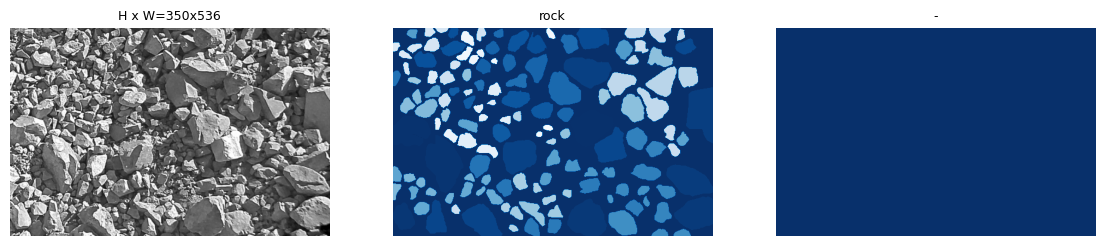

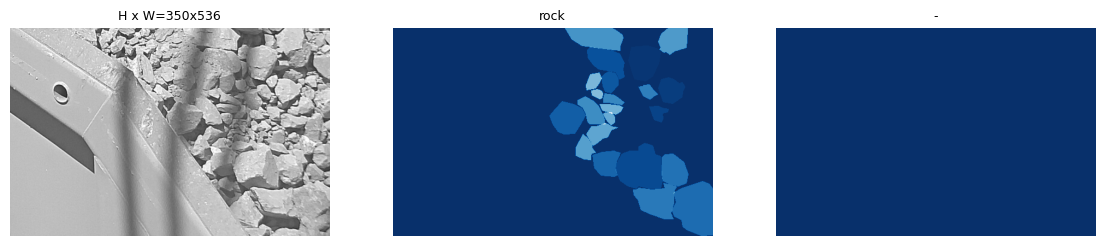

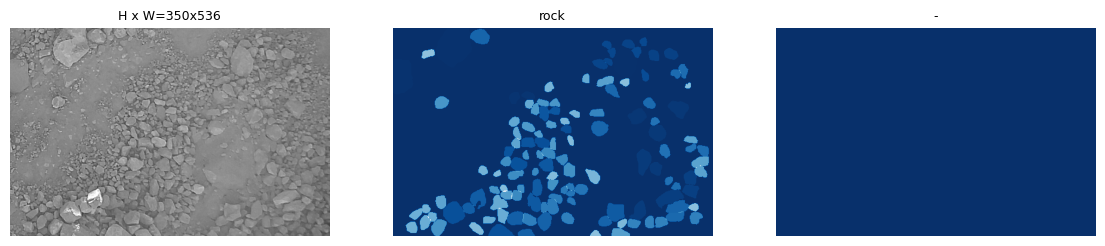

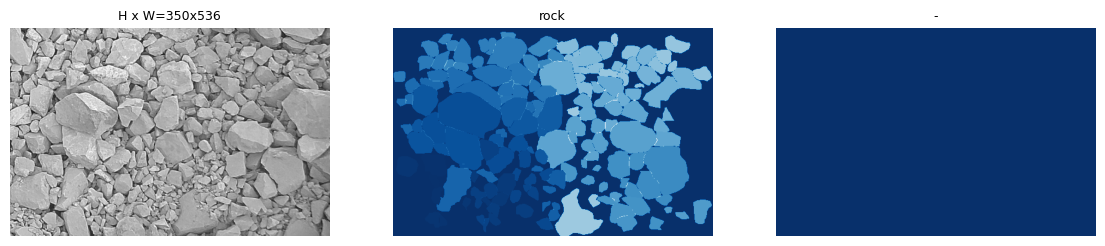

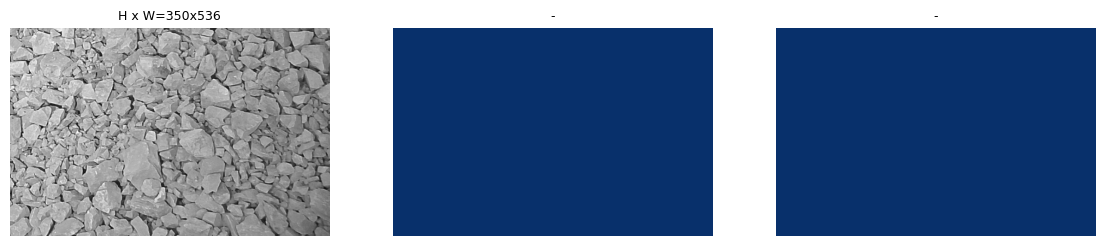

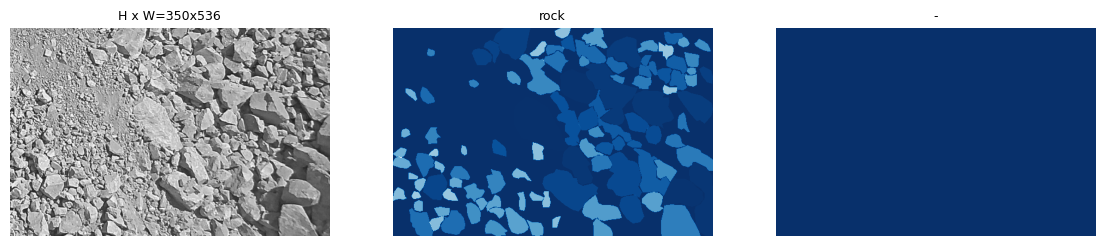

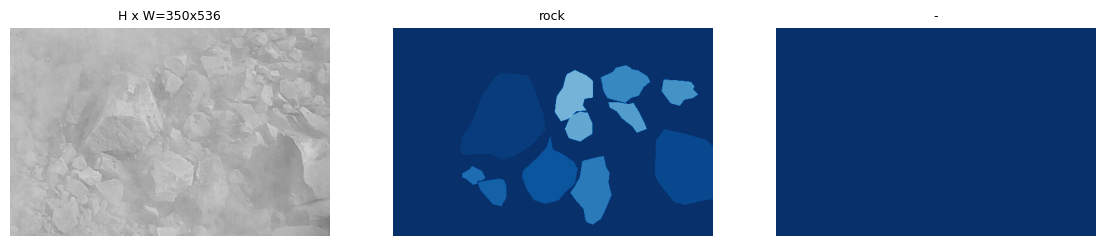

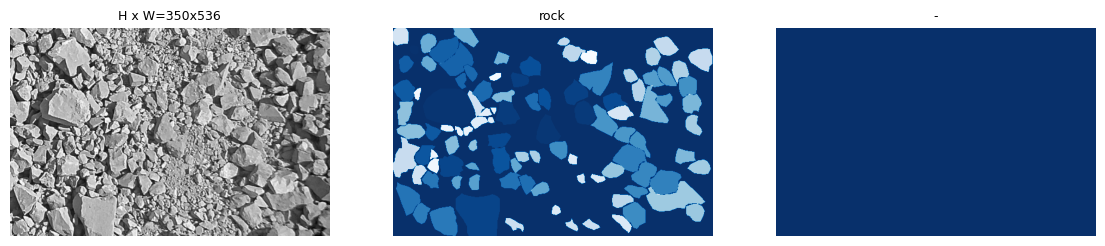

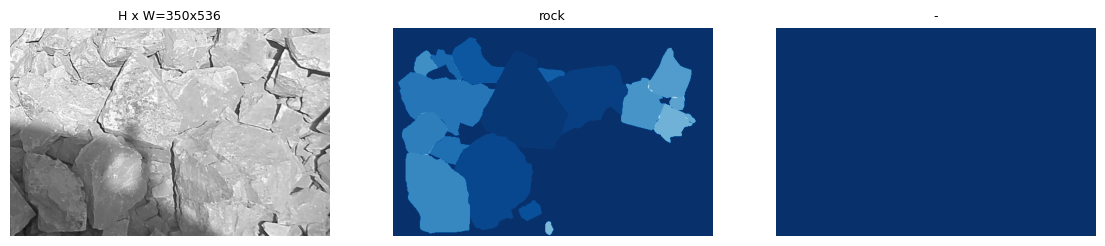

In [22]:
#Selecciona 5 im genes aleatorias i las visualiza con sus correspondientes m scaras
image_ids=np.random.choice(dataset_train.image_ids,10)
for image_id in image_ids:
  image = dataset_train.load_image(image_id)
  mask, class_ids = dataset_train.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,2)





In [23]:
# Crea el modelo del tarining mode
model = modellib.MaskRCNN(mode="training", config=config , model_dir=MODEL_DIR)
model.find_last()

self.model_dir: /content/logs
Dir_names: ['rock_data20231210T0032']


'/content/logs/rock_data20231210T0032/mask_rcnn_rock_data_0013.h5'

In [24]:
#Selecci n de las matrices de peso (coco o la ltima conseguida)
init_with = "last"
#init_with="last"

In [25]:
if init_with == "imagenet":
  model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
  #Excluyo par metros que no me interesan
  #model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
  model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_mask"]  )
elif init_with == "last":
  model.load_weights(model.find_last(), by_name=True)
  !pip list


self.model_dir: /content/logs
Dir_names: ['rock_data20231210T0032']
Re-starting from epoch 13
Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                  

In [26]:
Rock_augmentation = imgaug.augmenters.Sometimes(0.9,[imgaug.augmenters.geometric.Affine(rotate=(-360,360))])


In [27]:
import warnings
warnings.filterwarnings('ignore')

with tf.device('/device:GPU:0'):
  model.train(
        dataset_train
      , dataset_val
      , learning_rate=config.LEARNING_RATE
      , epochs=5
      , layers='heads'
      , augmentation = Rock_augmentation
      )




Starting at epoch 13. LR=0.005

Checkpoint Path: /content/logs/rock_data20231210T0032/mask_rcnn_rock_data_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Tim

In [28]:
with tf.device('/device:GPU:0'):
  model.train(dataset_train , dataset_val , learning_rate=config.LEARNING_RATE / 10,epochs=13, layers="all")


Starting at epoch 13. LR=0.0005

Checkpoint Path: /content/logs/rock_data20231210T0032/mask_rcnn_rock_data_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [38]:
newFolderLog="rock_data20231210T0032"
def copyFilesLogs(newFolderLog):
  #%cd /content/logs/
  os.chdir("/content/logs/")
  os.system("cp -r ./"+ newFolderLog +"/ /content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/logs/")
  #%cp -r "./"+newFolderLog+"/" /content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/logs/

copyFilesLogs(newFolderLog)

0

In [31]:
class InferenceConfig(Rocks):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1


In [33]:
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", config=inference_config ,model_dir=MODEL_DIR)


In [34]:
# Show stats of all trainable weights
visualize.display_weight_stats(model)

In [40]:
model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path , by_name=True)
model.keras_model.save("/content/logs/"+newFolderLog+"/model.hd")
copyFilesLogs(newFolderLog)

self.model_dir: /content/logs
Dir_names: ['rock_data20231210T0032']
Loading weights from  /content/logs/rock_data20231210T0032/mask_rcnn_rock_data_0013.h5
Re-starting from epoch 13


In [41]:
def get_ax(rows=1, cols=1, size=10):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

dataset_val.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [42]:
image_id=0
original_image , image_meta , gt_class_id ,gt_bbox , gt_mask = modellib.load_image_gt(dataset_val , inference_config , image_id )
#original_image , image_meta , gt_class_id ,gt_bbox , gt_mask = modellib.load_image_gt(dataset_val , inference_config , image_id, use_mini_mask=False)


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (72,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (72, 4)               min:    1.00000  max: 1011.00000  int32
gt_mask                  shape: (1024, 1024, 72)      min:    0.00000  max:    1.00000  uint8


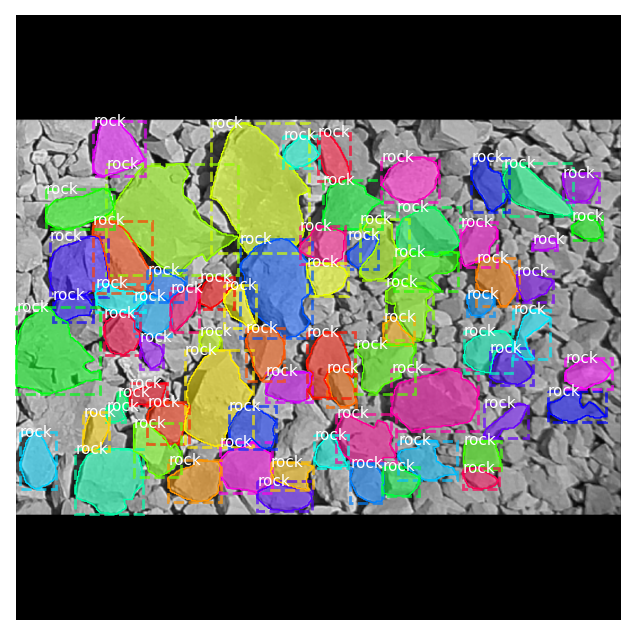

(72,)


In [43]:
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names, figsize=(8, 8))
print(gt_class_id.shape)

In [44]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


(90,)


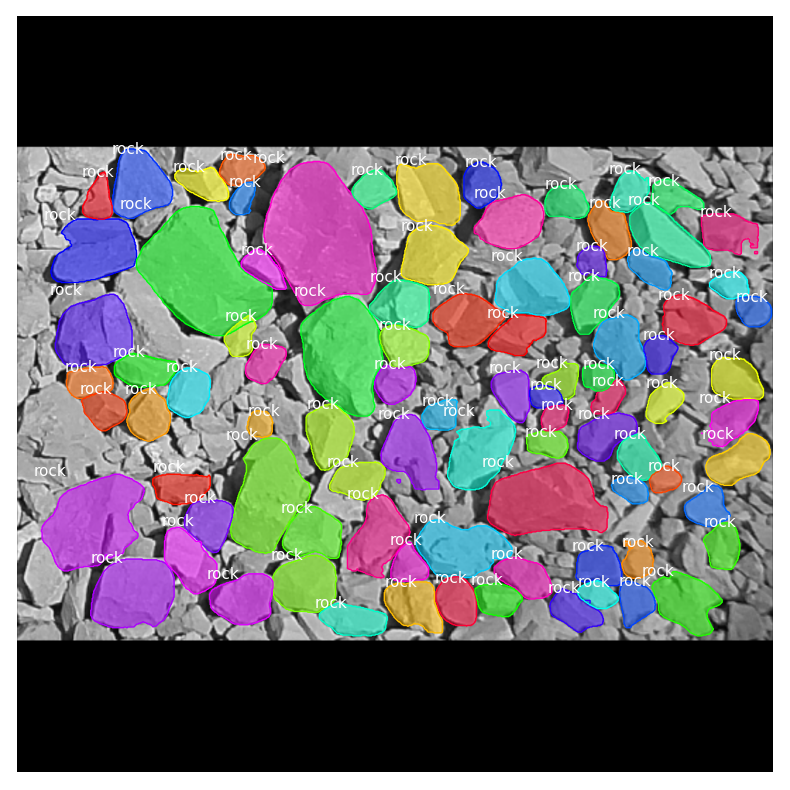

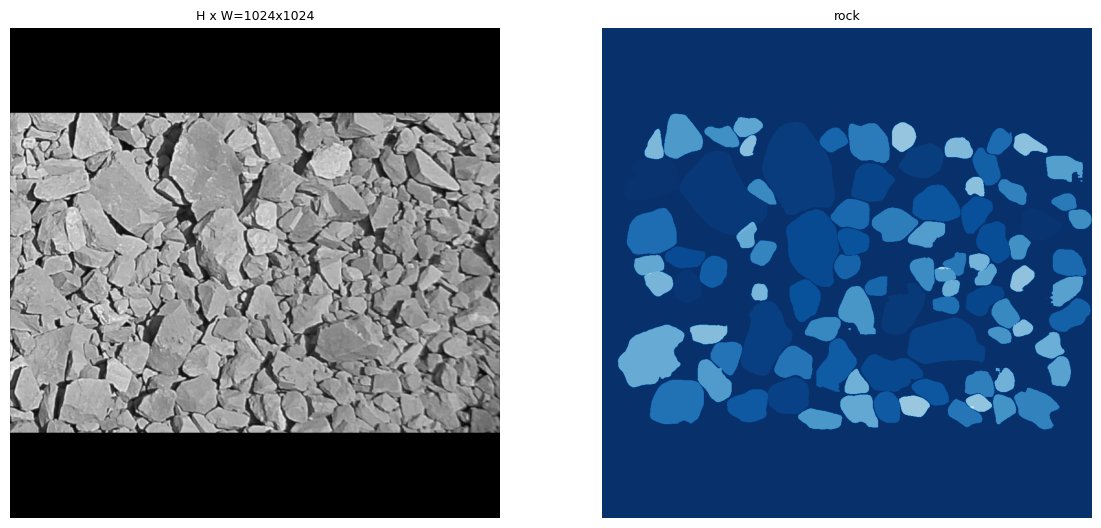

In [45]:
r = results[0]
#visualize.display_instances(original_image , r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())
#print(r['class_ids'].shape)
#def display_instances(image, boxes, masks, class_ids, class_names,
#                      scores=None, title="",
#                      figsize=(16, 16), ax=None,
#                      show_mask=True, show_bbox=True,
#                      colors=None, captions=None):

visualize.display_instances(original_image , r['rois'], r['masks'], r['class_ids'],  dataset_val.class_names,
                  scores=None, title="",
                  ax=get_ax(),show_mask=True,
                  show_bbox=False,captions=False)

print(r['class_ids'].shape)

visualize.display_top_masks(original_image, r['masks'], r['class_ids'], dataset_val.class_names,1)

In [46]:
#if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/Confusion-matrix-for-Mask-R-CNN'):
#  !git clone https://github.com/Altimis/Confusion-matrix-for-Mask-R-CNN.git


from mrcnn import utils
import pandas as pd
import numpy as np
import os
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  77
the actual len of the pred vect is :  77
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  159
the actual len of the pred vect is :  159
Processing 1 images
image             

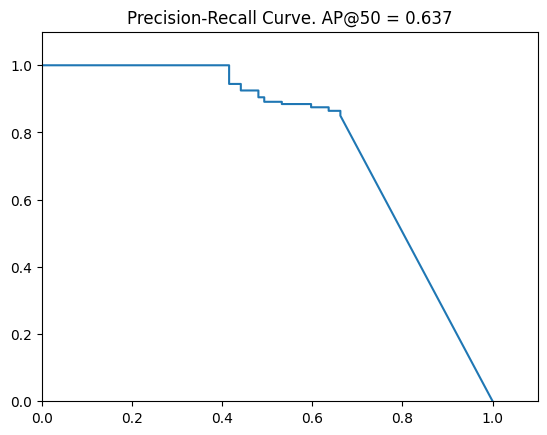

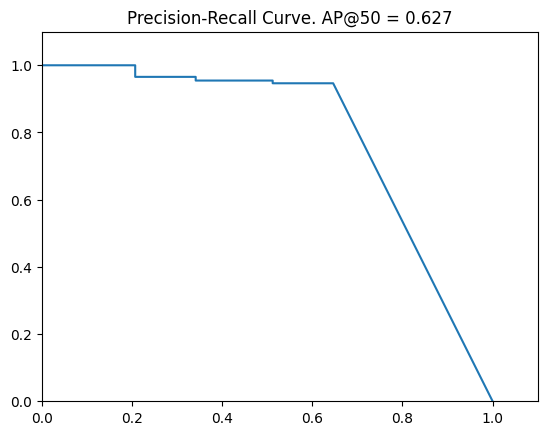

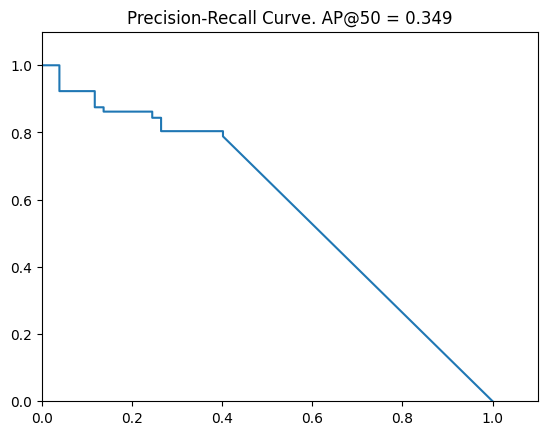

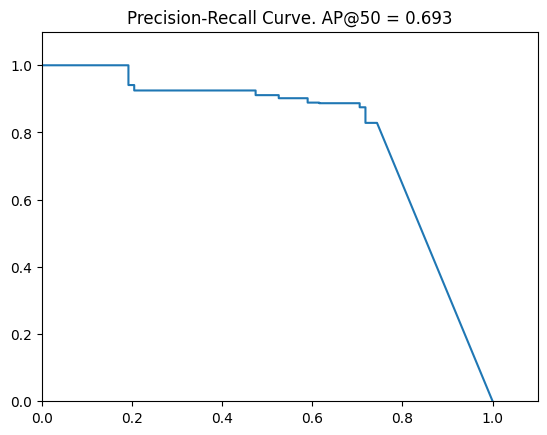

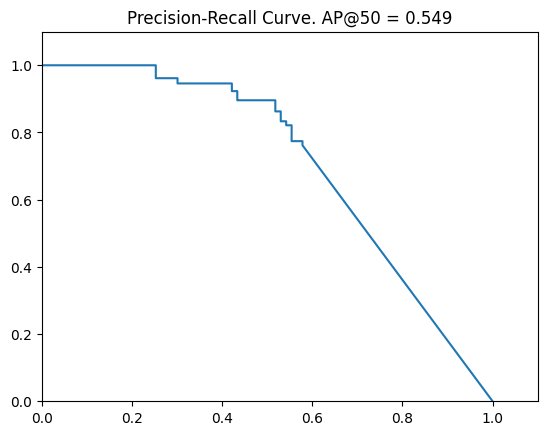

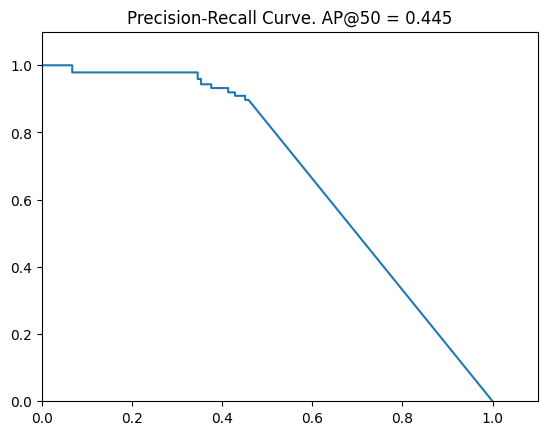

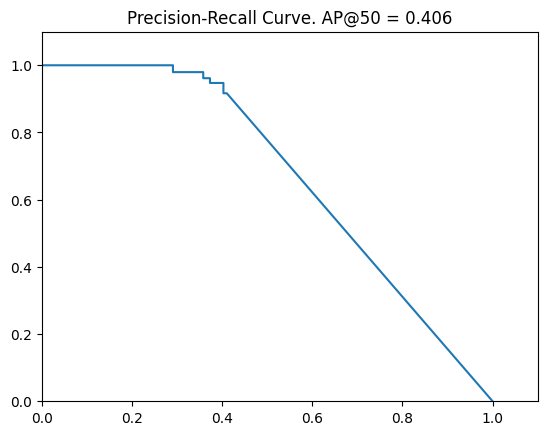

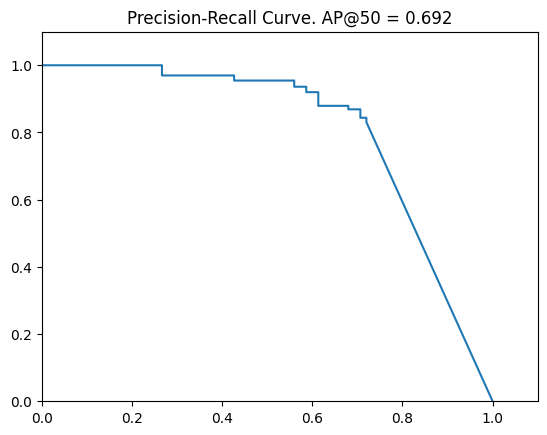

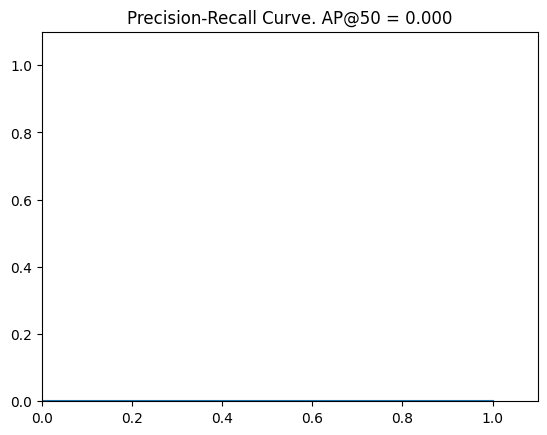

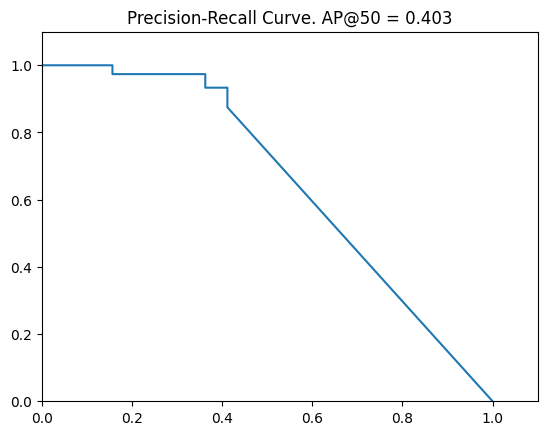

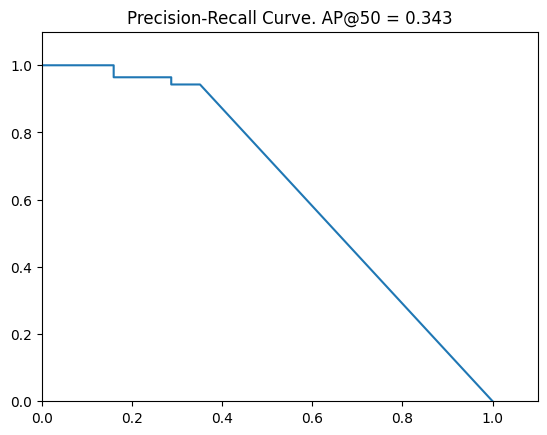

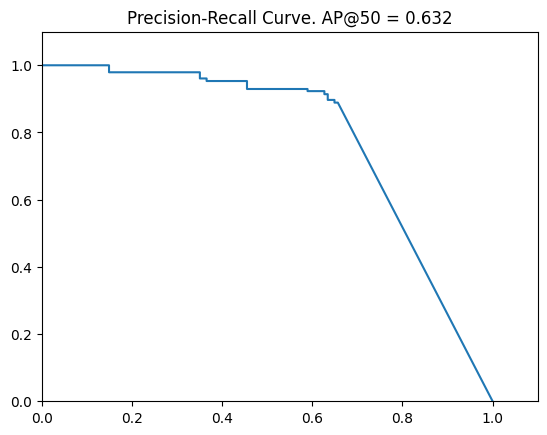

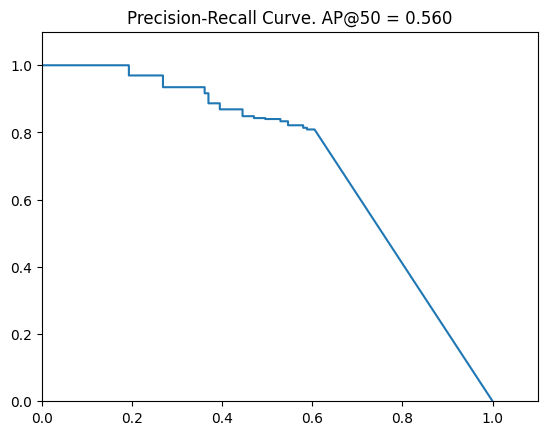

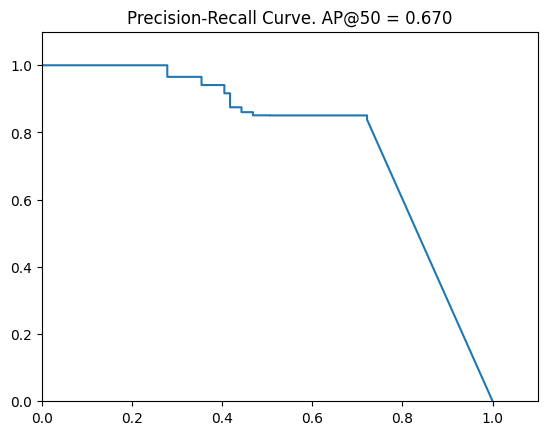

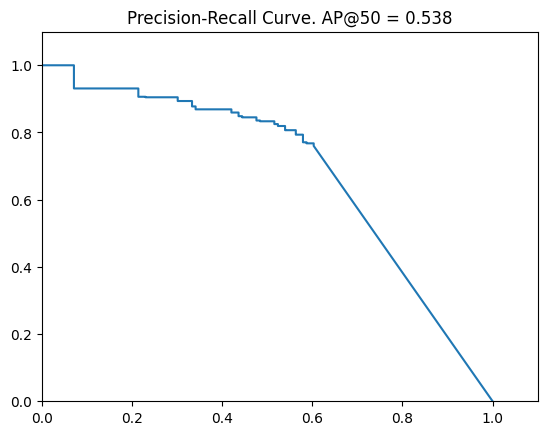

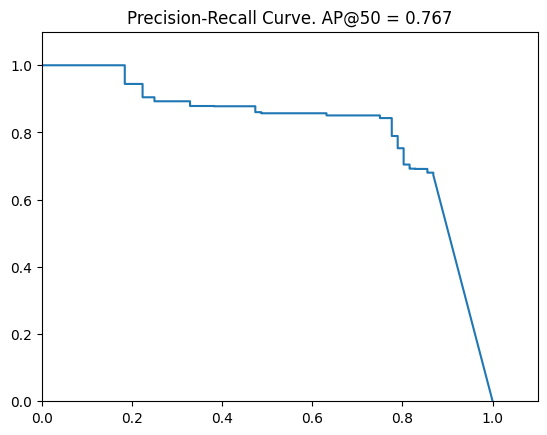

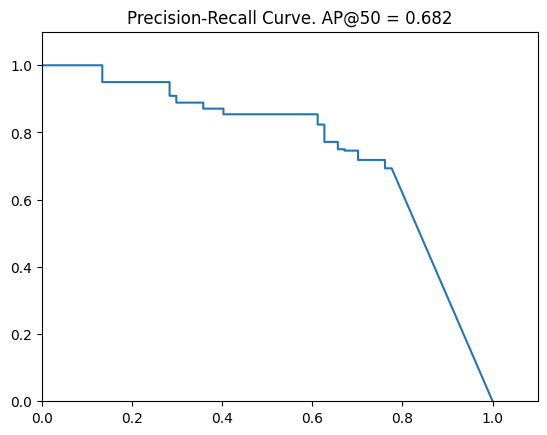

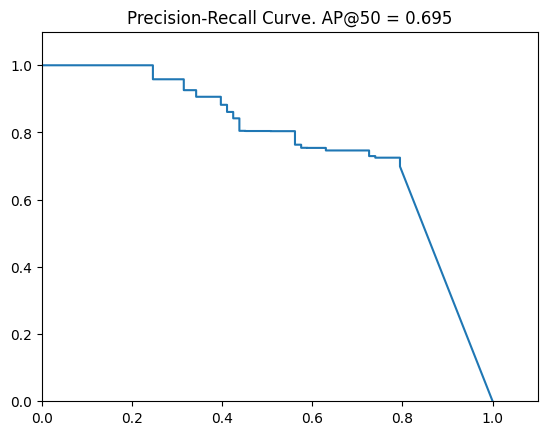

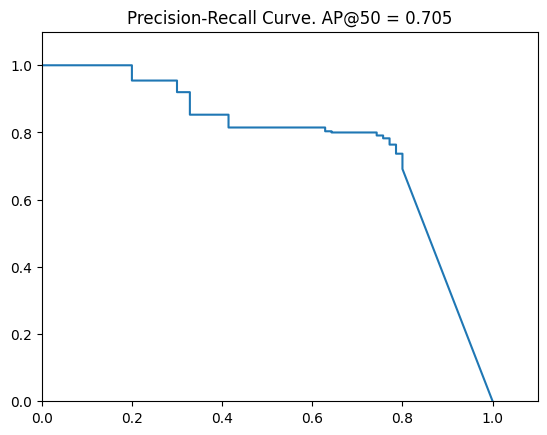

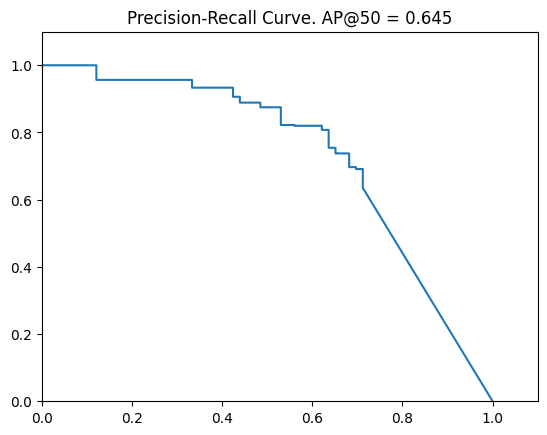

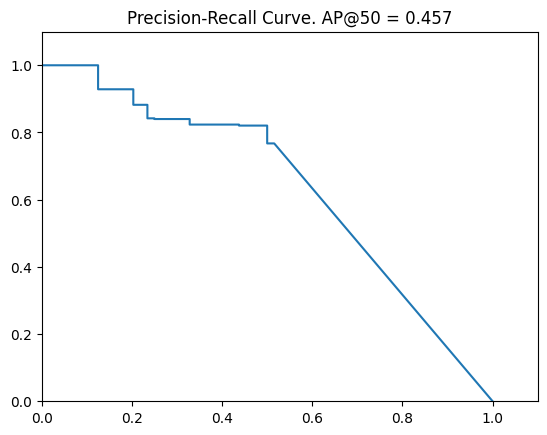

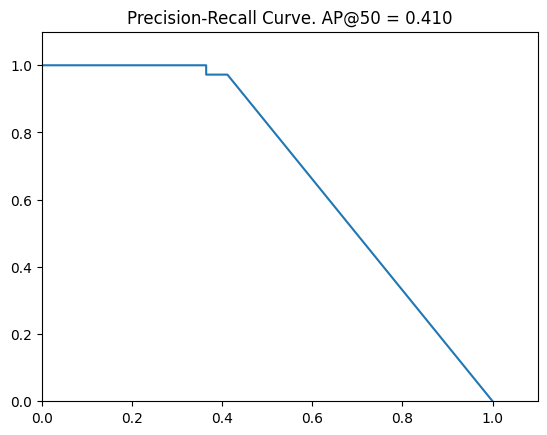

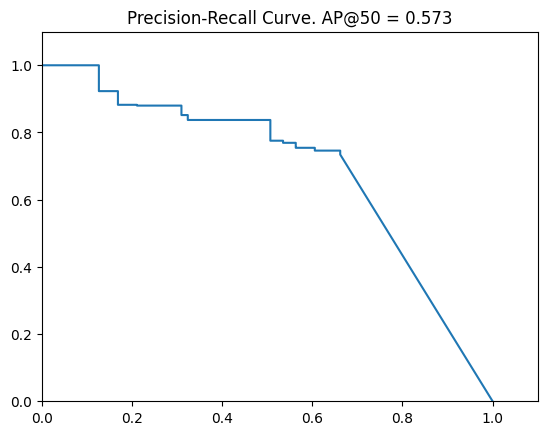

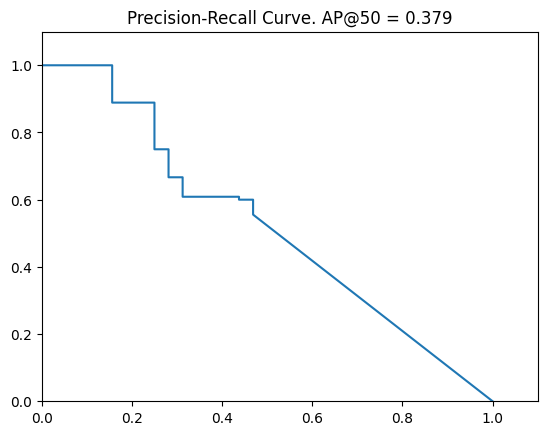

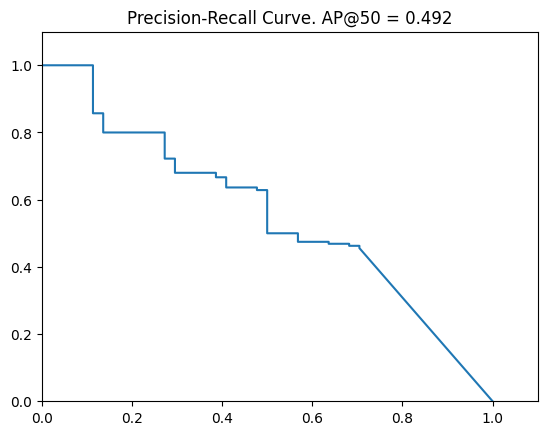

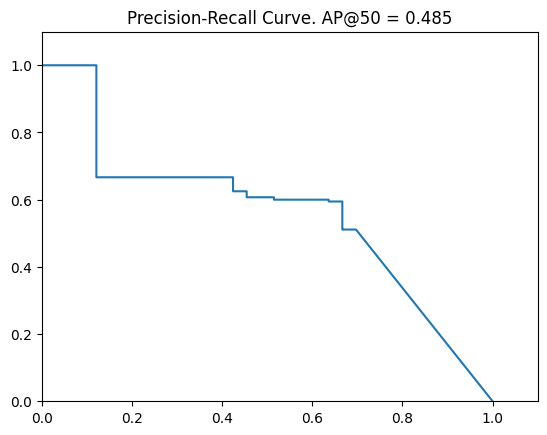

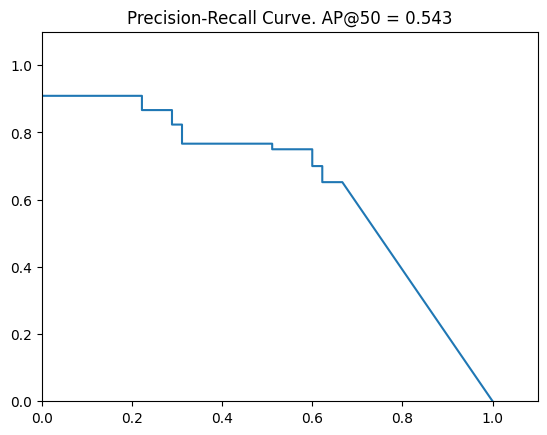

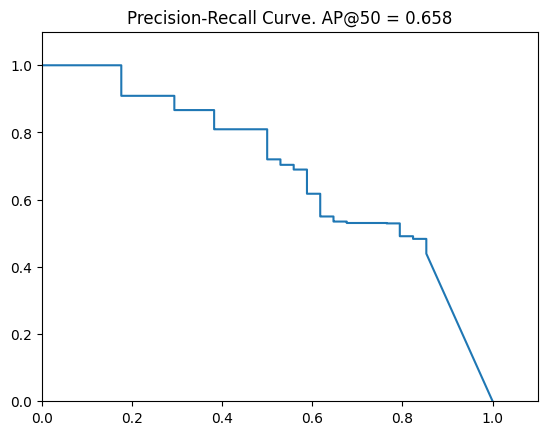

In [47]:
config=inference_config
for image_id in dataset_test.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_test, config, image_id)
  #modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
  modellib.load_image_gt(dataset_test, config, image_id)
  info=dataset_test.image_info[image_id]

  results = model.detect([image], verbose=1)
  r = results[0]

  gt, pred = utils.gt_pred_lists(gt_class_id,gt_bbox, r['class_ids'],  r['rois'])

  #print(len(pred))
  #print(len(gt_class_id))

  if(len(pred)>len(gt_class_id)):
      pred=pred[0:len(gt_class_id)]

  gt_tot = np.append(gt_tot, gt_class_id)
  pred_tot=np.append(pred_tot, pred)

  AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,r['rois'], r['class_ids'], r['scores'], r['masks'])
  visualize.plot_precision_recall(AP_, precision_, recall_)
  #visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'], overlap_, dataset_test.class_names)

  print("the actual len of the gt vect is : ", len(gt_tot))
  print("the actual len of the pred vect is : ", len(pred_tot))

  mAP_.append(AP_)

In [48]:
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
save_dir = "/content/output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
  os.makedirs(save_dir)
df.to_json(os.path.join(save_dir ,"gt_pred_test.json"))


ground truth list :  [1 1 1 ... 1 1 1]
predicted list :  [1 1 1 ... 0 0 0]


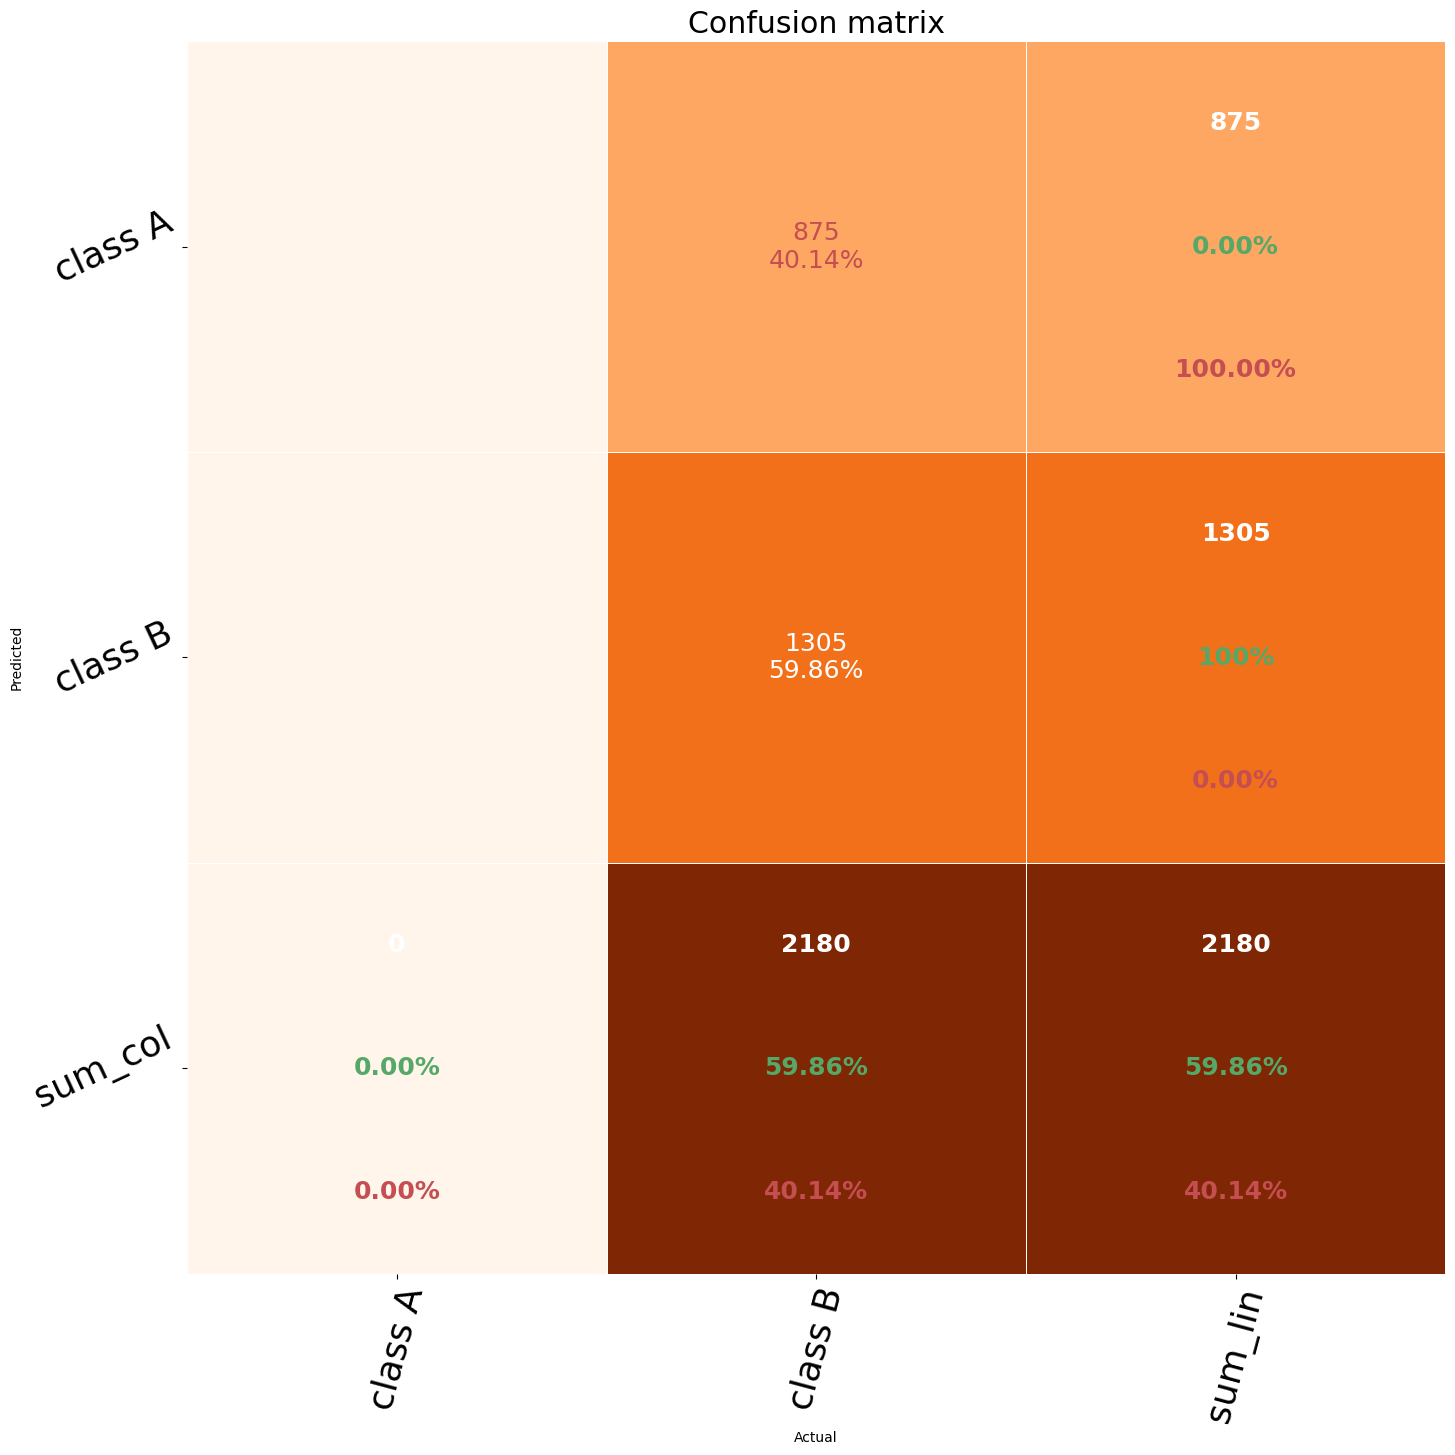

In [49]:
print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,fz=18, figsize=(15,15), lw=0.5)

Precisión Media mAP (mean average precision): 0.1812
Recall Promedio mAR: (mean average recall): 0.2492
F1-score :  0.20978947575864326


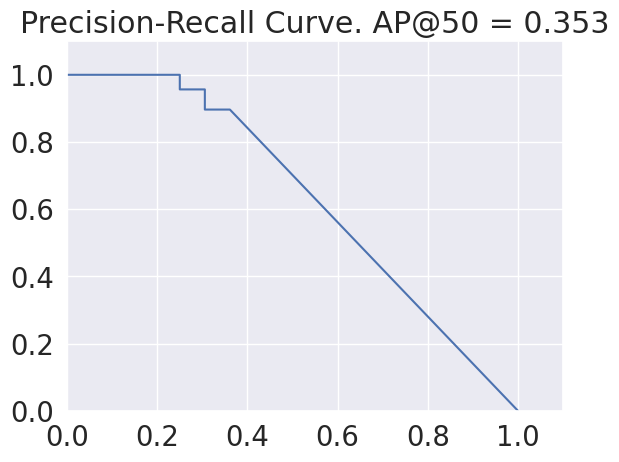

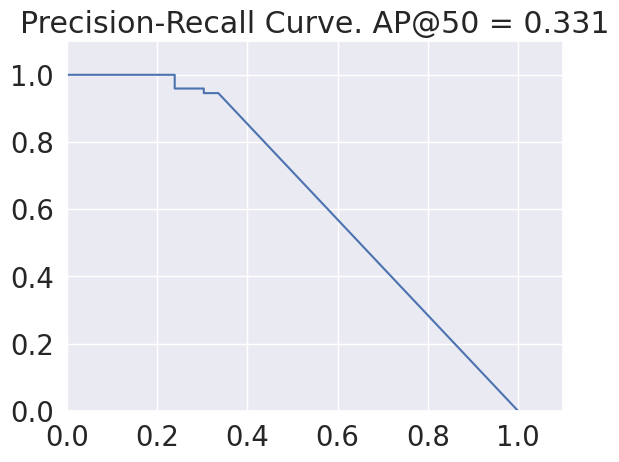

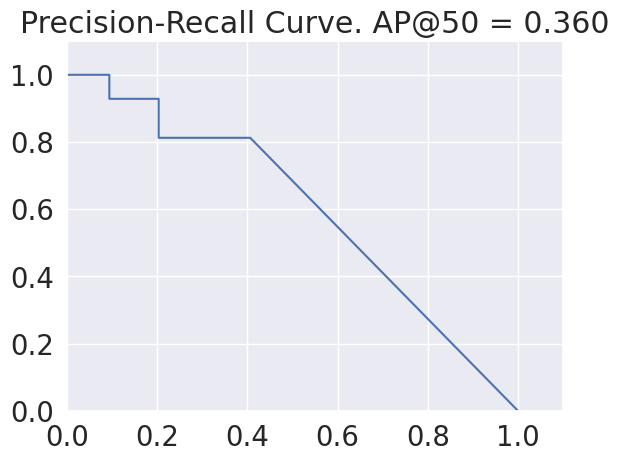

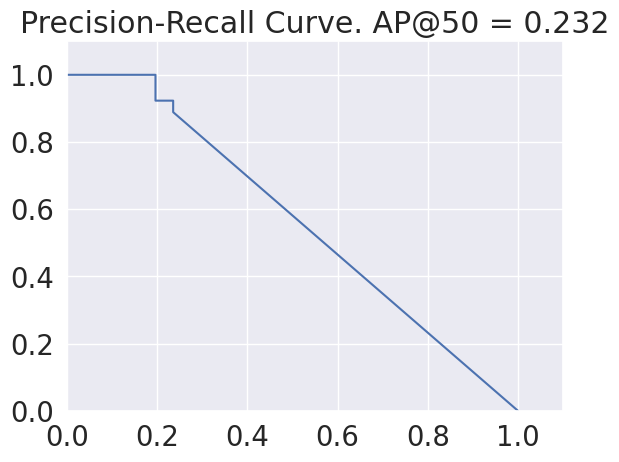

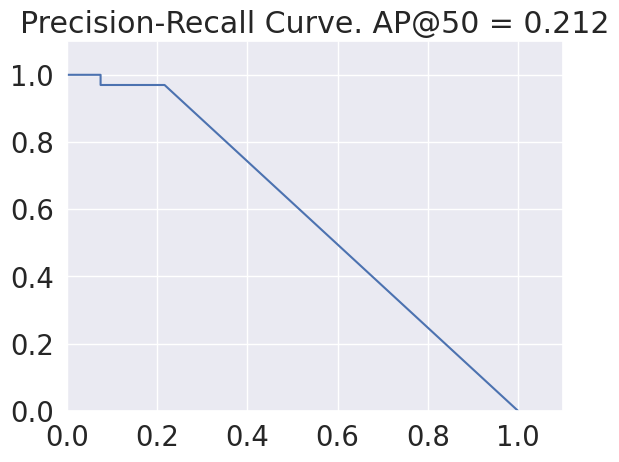

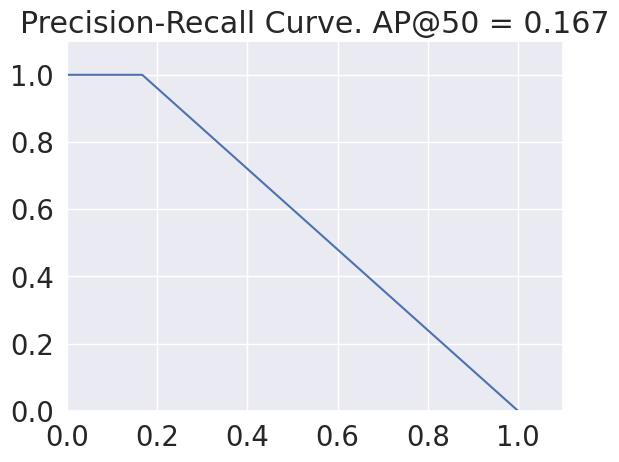

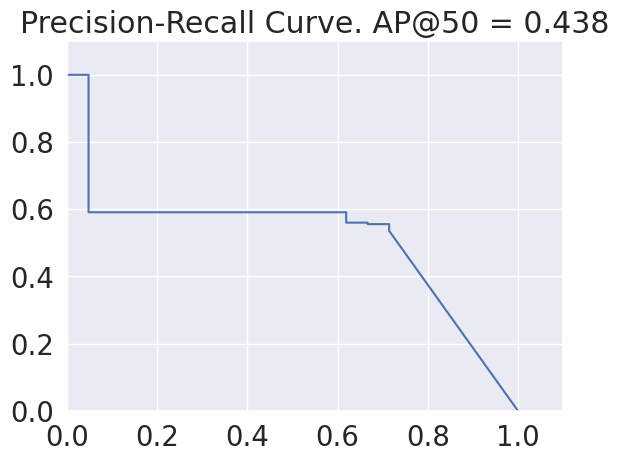

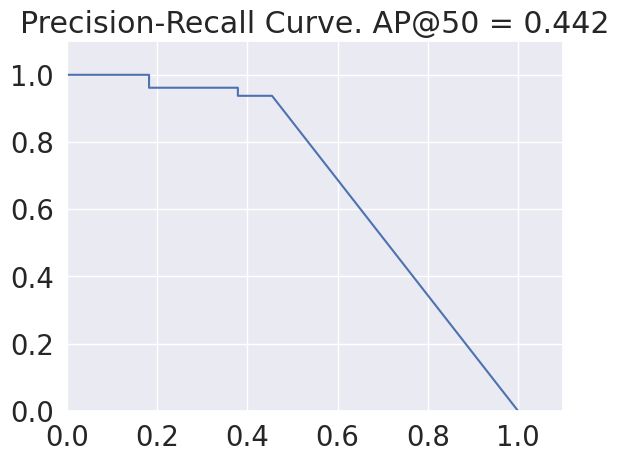

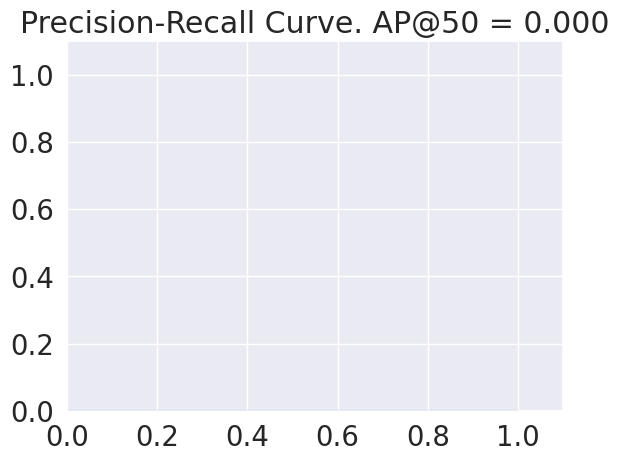

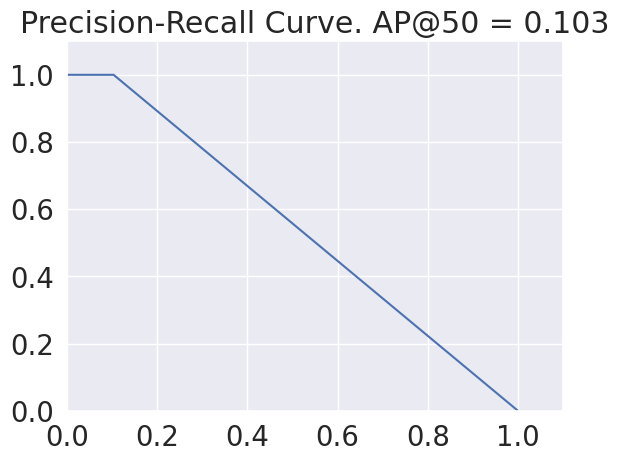

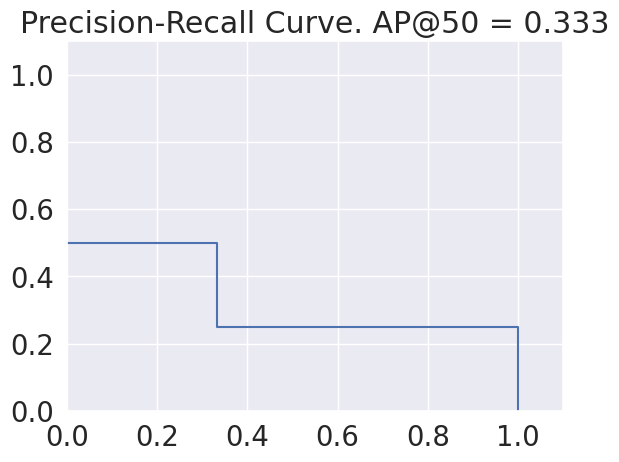

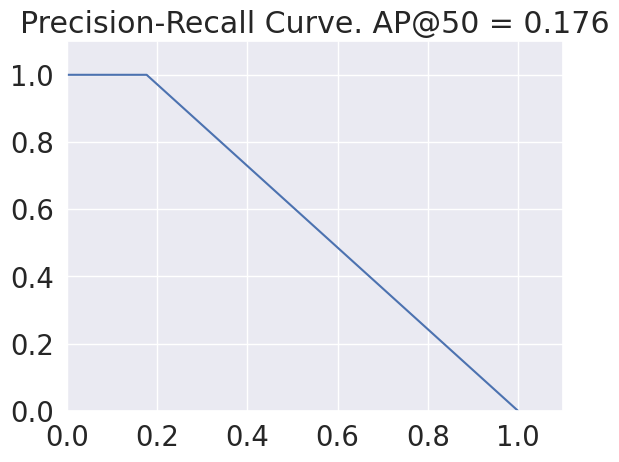

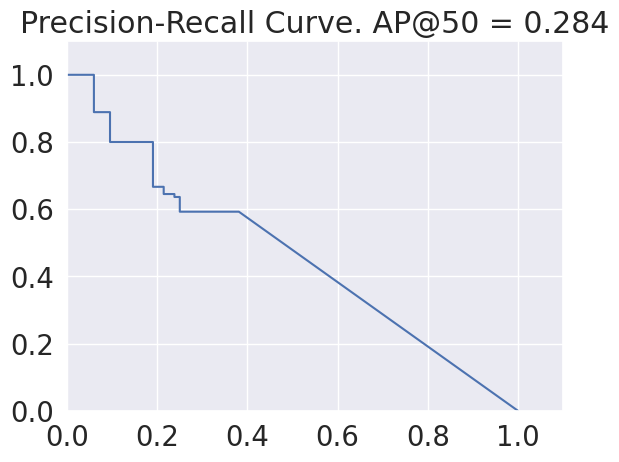

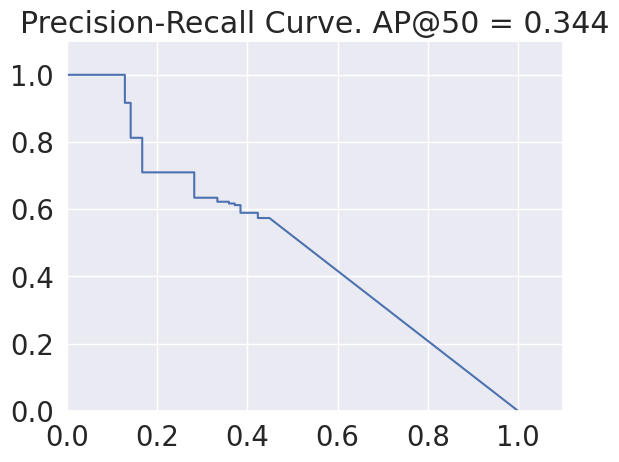

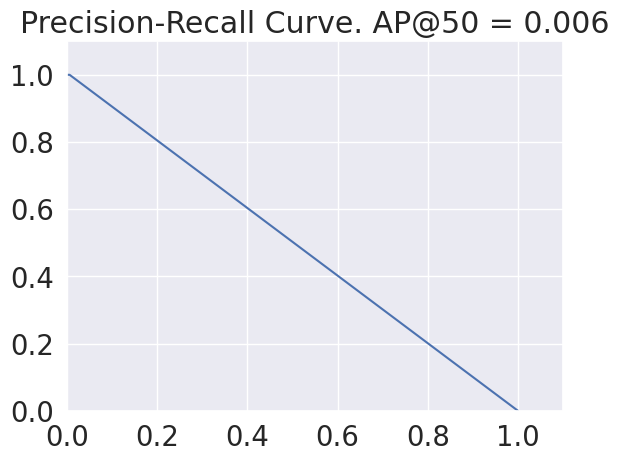

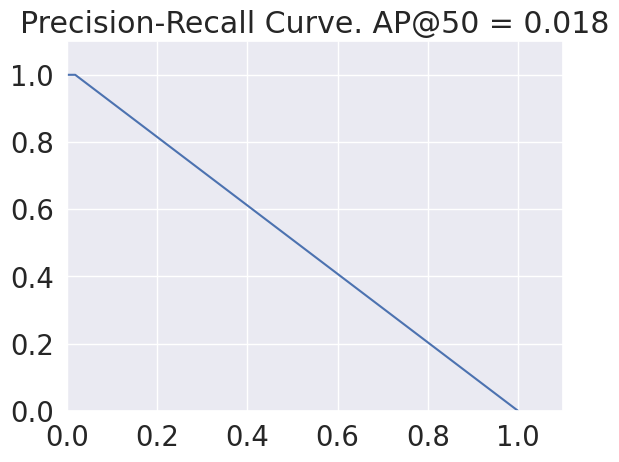

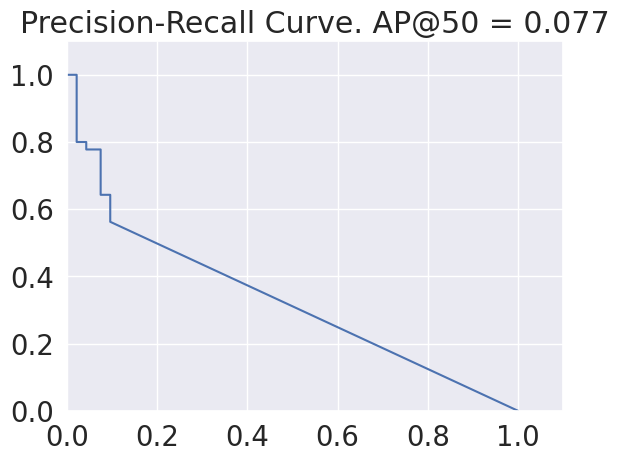

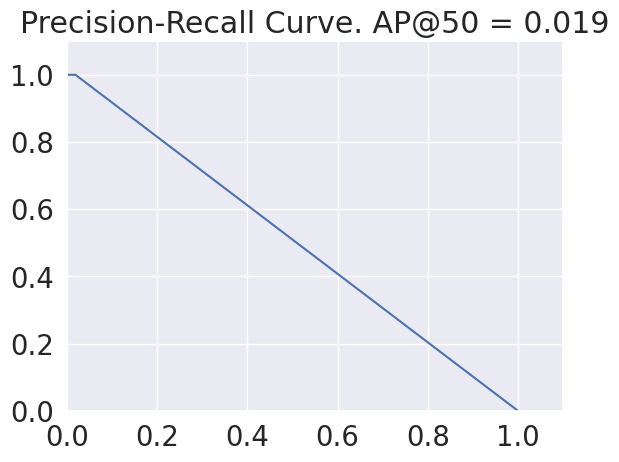

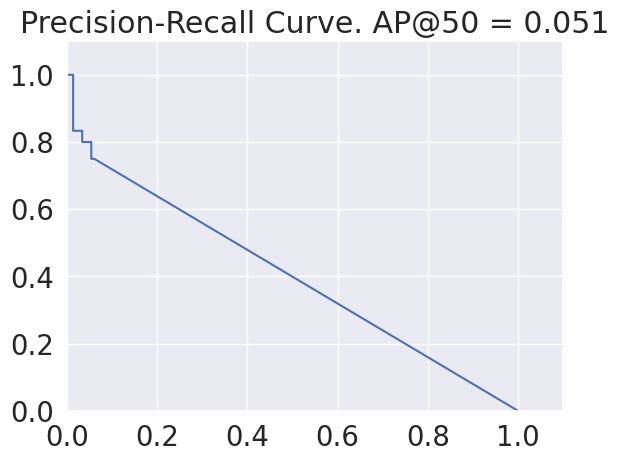

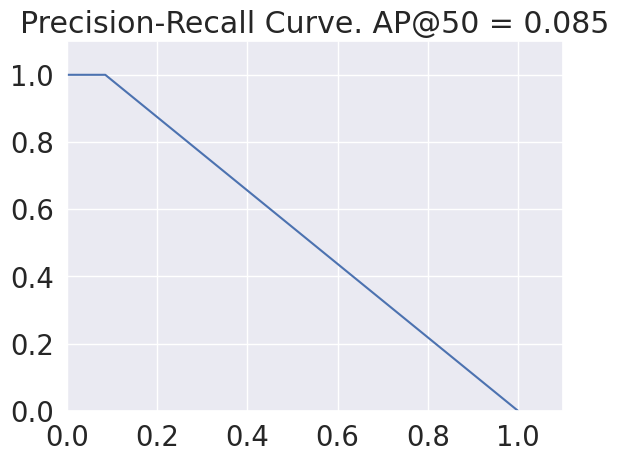

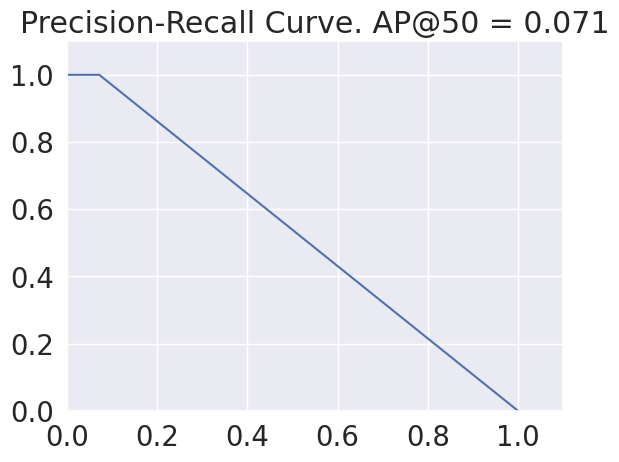

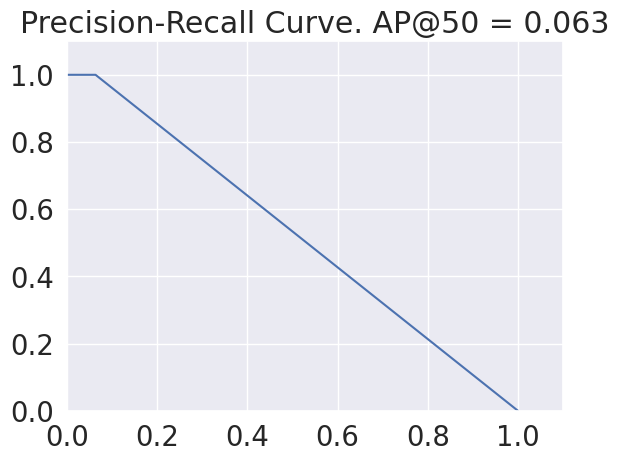

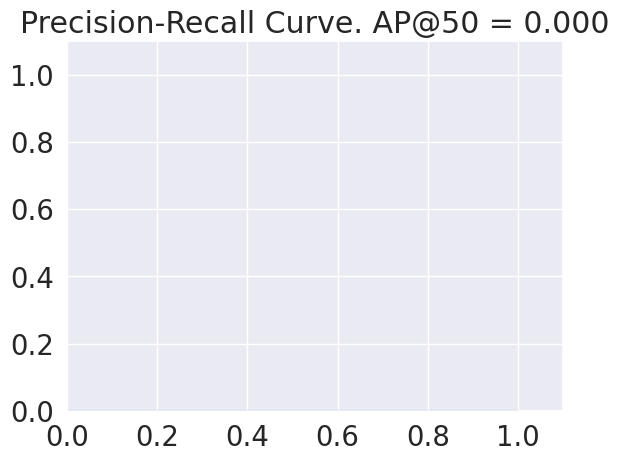

In [50]:
#Función para evaluar el modelo con las imágenes de validacion 10%
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap, compute_recall
from mrcnn import utils

from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

def evaluate_model(dataset, model, cfg):
    APs = list();
    ARs = list();
    F1_scores = list();
    for image_id in dataset.image_ids:
        #image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        AR, positive_ids = compute_recall(r["rois"], gt_bbox, iou=0.1)
        ARs.append(AR)
        F1_scores.append((2* (mean(precisions) * mean(recalls)))/(mean(precisions) + mean(recalls)))
        APs.append(AP)
        visualize.plot_precision_recall(AP, precisions, recalls)

    mAP = mean(APs)
    mAR = mean(ARs)
    return mAP, mAR, F1_scores

mAP, mAR, F1_score = evaluate_model(dataset_val, model, inference_config)
print("Precisión Media mAP (mean average precision): %.4f" % mAP)
print("Recall Promedio mAR: (mean average recall): %.4f" % mAR)

F1_score_2 = (2 * mAP * mAR)/(mAP + mAR)
print('F1-score : ', F1_score_2)

In [ ]:
#Se extraen los datos de p r d i d a s y se muestran con el tensorflow
os.chdir('/content/logs/')
import tensorflow.compat.v1 as tf
%load_ext tensorboard
sess = tf.Session()
path_logs = "/content/logs"
file_writer = tf.summary.FileWriter( path_logs , sess.graph )
%tensorboard --logdir /content/logs/

In [ ]:
!pip freeze > /content/requirements.txt